In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

commonlit_lm	  commonlitreadabilityprize.zip  test.csv	 train.csv
commonlit_lm.zip  sample_submission.csv		 train-orig.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
2,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
3,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
4,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
...,...,...,...,...,...,...
2839,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2840,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2841,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2842,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [6]:
train_df[train_df['excerpt'].str.contains('Robin Hood')]

,id,url_legal,license,excerpt,target,standard_error
227,21ea485fb,NaN,NaN,A little within the wood there was a fair cast...,-1.302688,0.450399
229,a04741371,NaN,NaN,"The king dwelt for many months in Nottingham, ...",-0.714009,0.506864
230,5cb5ab998,NaN,NaN,"When they drew near Nottingham, all the people...",-1.541347,0.478166
231,622f6215e,NaN,NaN,About this time there was living in Nottingham...,-2.054284,0.538084


In [7]:
train_df[train_df['id'] == '21ea485fb']['excerpt'].values

array(['A little within the wood there was a fair castle, with a double moat, and surrounded by stout walls. Here dwelt that noble knight, Sir Richard Lee, to whom Robin Hood had lent the four hundred pounds to redeem his land.\nHe saw the little company of outlaws fighting their way along, so he hastened to call them to come and take shelter in his castle.\n"Welcome art thou, Robin Hood! Welcome!" he cried, as he led them in. "Much I thank thee for thy comfort and courtesy and great kindness to me in the forest. There is no man in the world I love so much as thee. For all the proud Sheriff of Nottingham, here thou shalt be safe!—Shut the gates, and draw the bridge, and let no man come in!" he shouted to his retainers. "Arm you well; make ready; guard the walls! One thing, Robin, I promise thee: here shalt thou stay for twelve days as my guest, to sup, and eat, and dine."\nSwiftly and readily tables were laid and cloths spread, and Robin Hood and his merry men sat down to a good meal.'

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

1299   -3.351956
1300   -3.351956
Name: target, dtype: float64

In [9]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

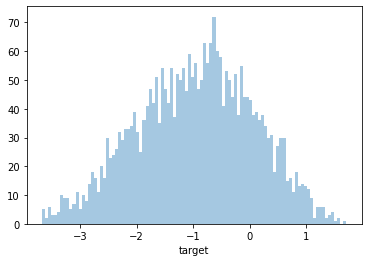

In [11]:
sns.distplot(train_df['target'],bins=100,kde=False)

### Prepare Cross Validation

In [12]:
target = train_df['target'].to_numpy()

In [13]:
num_bins = int(np.floor(np.log2(len(train_df))) + 1)
train_df.loc[:, 'bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)

In [14]:
train_df[['target', 'bins']].groupby(['bins']).agg(['mean', 'count'])

target      
          mean count
bins                
0    -3.411708    44
1    -2.969369    79
2    -2.526589   172
3    -2.106393   269
4    -1.652726   366
5    -1.201392   420
6    -0.748612   484
7    -0.309570   408
8     0.130016   312
9     0.560802   184
10    0.978923    83
11    1.399764    23

In [15]:
kf = StratifiedKFold(n_splits=num_bins)

In [16]:
for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
    train_df.loc[v_, 'kfold'] = i

In [17]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

In [18]:
train_df = train_df.drop('bins', axis=1)

In [19]:
train_df

,id,url_legal,license,excerpt,target,standard_error,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0
2,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0
3,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0
4,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,0
...,...,...,...,...,...,...,...
2839,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,11
2840,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,11
2841,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,11
2842,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,11


In [20]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[2, 8, 7, 0, 3, 5, 10, 4, 9, 6, 11, 1]

### Metrics

In [21]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [22]:
a = np.random.rand(10)
b = np.random.rand(10)

In [23]:
rmse_score(a, b), rmse_score_2(a, b)

(0.3034174425750427, 0.3034174425750427)

### Configuration

In [24]:
!mv /home/commonlit/models/roberta-base-lm /home/commonlit/models/roberta-base_lm

mv: cannot stat '/home/commonlit/models/roberta-base-lm': No such file or directory


In [25]:
class CONFIG():
    model_name = 'albert-base-v2'
    batch_size = 64
    max_len = 256
    save_dir = f'trained/{model_name}'
    num_workers = 4
    epochs = 30
    pretrained_transformers_model = f'/home/commonlit/models/{model_name}_lm/best_lm'

In [26]:
cfg = CONFIG()

In [27]:
assert Path(cfg.pretrained_transformers_model).exists()

### Prepare train test split

In [28]:
def create_split(fold = [1]):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df['excerpt'].values
    valid_target = valid_df['target'].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df['excerpt'].values
    train_target = training_df['target'].values
    return train_text, train_target, valid_text, valid_target

In [29]:
train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2607, 237)

### Prepare Tokenizers

In [30]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
tokenizer.save_pretrained(cfg.save_dir)

('trained/albert-base-v2/tokenizer_config.json',
 'trained/albert-base-v2/special_tokens_map.json',
 'trained/albert-base-v2/spiece.model',
 'trained/albert-base-v2/added_tokens.json',
 'trained/albert-base-v2/tokenizer.json')

In [31]:
encoded_dict = tokenizer(train_df['excerpt'].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

'[CLS] when the young people returned to the ballroom, it presented a decidedly changed appearance. instead of an interior scene, it was a winter landscape. the floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. the numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches. at each end of the room, on the wall, hung a beautiful bear-skin rug. these rugs were for prizes, one for the girls and one for the boys. and this was the game. the girls were gathered at one end of the room and the boys at the other, and one end was called the north pole, and the other the south pole. each player was given a small flag which they were to plant on reaching the pole. this would have been an easy matter, but each traveller was obliged to wear snowshoes.[

In [32]:
encoded_dict['input_ids'].shape

torch.Size([1, 256])

In [33]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, max_len=128):
        self.excerpt = text
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return InputFeatures(input_ids=convert_to_list(encode['input_ids']),
                      attention_mask=convert_to_list(encode['attention_mask']),
                      label=torch.tensor(self.target[idx]))
    
    def __len__(self):
        return len(self.excerpt)

In [34]:
def create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, cfg.max_len)
    return train_ds, valid_ds

In [35]:
# encode.keys(), target.shape, encode['input_ids'].shape, encode['attention_mask'].shape

In [36]:
# encode['input_ids'][0].squeeze()

### Model

In [37]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

In [38]:
# transformer_out = transformer_model(input_ids=encode['input_ids'].squeeze(), attention_mask=encode['attention_mask'].squeeze())

In [39]:
# dict(transformer_out)['last_hidden_state'].shape

In [40]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [41]:
# sample_layer = nn.Linear(768, 1)

In [42]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [43]:
model_config

AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

In [44]:
from torch.nn import functional as F

In [45]:
from transformers import PreTrainedModel

class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.drop = nn.Dropout(0.5)
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        self.out = nn.Linear(self.config.hidden_size, 1)
#         self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze(), output_hidden_states=False)
        x = transformer_out.pooler_output
#         x = transformer_out.last_hidden_state[:, 0, :] # N, C, X
        x = self.layer_norm(x)
        x = self.drop(x)
        x = self.out(x)
        return x
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [46]:
model = CommonLitModel()

Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

In [47]:
encoded_dict.input_ids.shape

torch.Size([1, 256])

In [48]:
transformer_model = transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), output_hidden_states=True)

In [49]:
sample_out.pooler_output.shape

torch.Size([1, 768])

In [50]:
sample_out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [51]:
sample_out['last_hidden_state'].shape, sample_out['last_hidden_state'][:, 0].shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [52]:
train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)

In [53]:
encode = train_ds[0]

In [54]:
encode.attention_mask.unsqueeze(0).shape, encoded_dict.input_ids.shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [55]:
sample_out = transformer_model(encode.input_ids.unsqueeze(0).cuda(), encode.attention_mask.unsqueeze(0).cuda())

### Training

In [56]:
import wandb

In [57]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

loss_fct = nn.MSELoss()

In [58]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='mse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=5e-5
    )
    return training_args

In [59]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'mse': mean_squared_error(logits, labels), 'rmse': rmse_score_2(logits, labels)}

In [60]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [61]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss

In [62]:
cfg.model_name

'albert-base-v2'

In [63]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

In [64]:
%%time

from transformers import EarlyStoppingCallback

bin_step = 1
bestmodels = []
eval_rmses = []
for i in range(0, num_bins, bin_step):
    train_bins = bin_list[i:i+bin_step]
    print('train_bins', f'{i}: {train_bins}')
    tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
    train_text, train_target, valid_text, valid_target = create_split([i])
    train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)
    training_args = create_training_args(i)
    model = CommonLitModel()
    wandb.init(project=f"commonlit_{cfg.model_name.replace('/', '_')}")
    trainer = CommonLitTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=12)]
    )
    trainer.train()
    trainer.save_model()
    print('training_args.output_dir', training_args.output_dir)
    tokenizer.save_pretrained(training_args.output_dir)
    result = trainer.evaluate()
    bestmodels.append(trainer.state.best_model_checkpoint)
    print('best_model_checkpoint', trainer.state.best_model_checkpoint)
    print('result', result)
    eval_rmses.append(result['eval_rmse'])

train_bins 0: [2]


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.868000,0.634268,0.634268,0.796409
2,0.695200,0.677475,0.677475,0.823089
3,0.557800,0.673295,0.673295,0.820546
4,0.436100,0.305963,0.305963,0.553139
5,0.321800,0.458530,0.458530,0.677148
6,0.280700,0.289263,0.289263,0.537831
7,0.226900,0.326592,0.326592,0.571482
8,0.193300,0.398987,0.398987,0.631654
9,0.161000,0.316295,0.316295,0.562401
10,0.140300,0.294734,0.294734,0.542894


training_args.output_dir /home/commonlit/models/albert-base-v2-0


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-0/checkpoint-246
result {'eval_loss': 0.2892626225948334, 'eval_mse': 0.28926265239715576, 'eval_rmse': 0.5378314256668091, 'eval_runtime': 1.6453, 'eval_samples_per_second': 144.044, 'epoch': 18.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 1: [8]


train/loss,0.0513
train/learning_rate,2e-05
train/epoch,18.0
train/global_step,738
_runtime,482
_timestamp,1623323075
_step,38
eval/loss,0.28926
eval/mse,0.28926
eval/rmse,0.53783
eval/runtime,1.6453


train/loss,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,▇██▁▄▁▂▃▁▁▂▃▁▂▁▁▂▁▁
eval/mse,▇██▁▄▁▂▃▁▁▂▃▁▂▁▁▂▁▁
eval/rmse,▇██▁▄▁▂▃▂▁▂▃▁▂▁▁▃▂▁
eval/runtime,▁▂▄▆█▅▇▆▄▄▄▄▄▄▄▄▄▄▅


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.535400,0.893412,0.893412,0.945205
2,0.794600,0.461461,0.461461,0.679309
3,0.619400,0.467660,0.467660,0.683857
4,0.457600,0.374209,0.374209,0.611726
5,0.462400,0.436102,0.436102,0.660380
6,0.295600,0.344552,0.344552,0.586985
7,0.259500,0.587651,0.587651,0.766584
8,0.251300,0.433929,0.433929,0.658733
9,0.181500,0.375306,0.375306,0.612622
10,0.147300,0.384719,0.384719,0.620257


training_args.output_dir /home/commonlit/models/albert-base-v2-1


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-1/checkpoint-1025
result {'eval_loss': 0.3117281496524811, 'eval_mse': 0.31172817945480347, 'eval_rmse': 0.558326244354248, 'eval_runtime': 1.6654, 'eval_samples_per_second': 142.307, 'epoch': 30.0, 'eval_mem_cpu_alloc_delta': 4096, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 2: [7]


train/loss,0.0126
train/learning_rate,0.0
train/epoch,30.0
train/global_step,1230
_runtime,799
_timestamp,1623323886
_step,62
eval/loss,0.31173
eval/mse,0.31173
eval/rmse,0.55833
eval/runtime,1.6654


train/loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval/loss,█▃▃▂▂▁▄▂▂▂▂▁▃▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/mse,█▃▃▂▂▁▄▂▂▂▂▁▃▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/rmse,█▃▃▂▃▂▅▃▂▂▂▁▃▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
eval/runtime,▁▁▂▂▄▁█▁█▂▃▂▃▄▂▂▃▇▃▂▂▃▂▁▂▂▂▂▁▂▃


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.682700,0.526955,0.526955,0.725917
2,0.673600,0.400206,0.400206,0.632618
3,0.552700,0.386953,0.386953,0.622056
4,0.512700,0.392408,0.392408,0.626425
5,0.390700,0.464228,0.464228,0.681343
6,0.274900,0.360454,0.360454,0.600378
7,0.417100,0.570301,0.570301,0.755183
8,0.255600,0.428032,0.428032,0.654242
9,0.205800,0.330620,0.330620,0.574996
10,0.127200,0.388054,0.388054,0.622940


training_args.output_dir /home/commonlit/models/albert-base-v2-2


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-2/checkpoint-984
result {'eval_loss': 0.3077722191810608, 'eval_mse': 0.30777227878570557, 'eval_rmse': 0.5547722578048706, 'eval_runtime': 1.6568, 'eval_samples_per_second': 143.044, 'epoch': 30.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 3: [0]


train/loss,0.0127
train/learning_rate,0.0
train/epoch,30.0
train/global_step,1230
_runtime,799
_timestamp,1623324692
_step,62
eval/loss,0.30777
eval/mse,0.30777
eval/rmse,0.55477
eval/runtime,1.6568


train/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval/loss,▇▃▃▃▅▂█▄▂▃▂▂▁▂▂▂▃▂▂▁▂▁▂▁▁▁▂▁▁▁▁
eval/mse,▇▃▃▃▅▂█▄▂▃▂▂▁▂▂▂▃▂▂▁▂▁▂▁▁▁▂▁▁▁▁
eval/rmse,▇▄▃▄▅▃█▄▂▃▂▂▂▂▂▂▃▂▂▁▂▂▂▁▁▁▂▁▁▁▁
eval/runtime,▁▂▃▂▁▃▆▃▁█▂▂▁▁▂▁▃▄▇▁▇▂▃▃▁▂▂▃▂▃▂


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.816700,0.548133,0.548134,0.740360
2,0.789500,0.563004,0.563004,0.750336
3,0.624200,0.556348,0.556348,0.745888
4,0.573800,0.519139,0.519139,0.720513
5,0.433600,0.664082,0.664082,0.814912
6,0.438100,0.299426,0.299426,0.547199
7,0.251200,0.302575,0.302575,0.550068
8,0.195800,0.456662,0.456662,0.675767
9,0.165400,0.570241,0.570241,0.755143
10,0.198400,0.372029,0.372029,0.609942


training_args.output_dir /home/commonlit/models/albert-base-v2-3


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-3/checkpoint-451
result {'eval_loss': 0.2472461462020874, 'eval_mse': 0.2472461760044098, 'eval_rmse': 0.49723854660987854, 'eval_runtime': 1.6663, 'eval_samples_per_second': 142.233, 'epoch': 23.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 4: [3]


train/loss,0.0272
train/learning_rate,1e-05
train/epoch,23.0
train/global_step,943
_runtime,615
_timestamp,1623325315
_step,48
eval/loss,0.24725
eval/mse,0.24725
eval/rmse,0.49724
eval/runtime,1.6663


train/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,▆▆▆▆█▂▂▅▆▃▁▂▁▂▁▂▁▁▁▁▁▁▁▁
eval/mse,▆▆▆▆█▂▂▅▆▃▁▂▁▂▁▂▁▁▁▁▁▁▁▁
eval/rmse,▆▇▆▆█▂▂▅▇▃▁▂▁▂▁▂▁▁▁▁▁▂▁▁
eval/runtime,▅▂▂▁▂█▃▃▁▂▁▇▁▂▂▄▃▄▂▃▂▂▃▃


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.731100,0.697799,0.697798,0.835343
2,0.844500,0.478556,0.478556,0.691777
3,0.665600,0.603157,0.603157,0.776632
4,0.493300,0.461598,0.461598,0.679410
5,0.412800,0.482615,0.482615,0.694705
6,0.330500,0.413945,0.413945,0.643386
7,0.255500,0.355439,0.355439,0.596187
8,0.186700,0.372906,0.372906,0.610660
9,0.209800,0.396699,0.396699,0.629840
10,0.177800,0.352737,0.352738,0.593917


training_args.output_dir /home/commonlit/models/albert-base-v2-4


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-4/checkpoint-492
result {'eval_loss': 0.34965503215789795, 'eval_mse': 0.34965503215789795, 'eval_rmse': 0.5913163423538208, 'eval_runtime': 1.6666, 'eval_samples_per_second': 142.204, 'epoch': 24.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 5: [5]


train/loss,0.03
train/learning_rate,1e-05
train/epoch,24.0
train/global_step,984
_runtime,639
_timestamp,1623325958
_step,50
eval/loss,0.34966
eval/mse,0.34966
eval/rmse,0.59132
eval/runtime,1.6666


train/loss,█▆▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,█▄▆▃▄▂▁▁▂▁▁▁▂▂▁▁▁▁▂▂▄▂▂▁▁
eval/mse,█▄▆▃▄▂▁▁▂▁▁▁▂▂▁▁▁▁▂▂▄▂▂▁▁
eval/rmse,█▄▆▄▄▂▁▂▂▁▁▁▂▂▁▁▁▁▂▂▄▂▂▁▁
eval/runtime,▃▂▇▂▂▂▂▂▂▂▂▂▇▃█▇▃▂▁▁▂▂▂▇▄


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.980000,0.402462,0.402462,0.634399
2,0.596300,0.380611,0.380611,0.616937
3,0.642300,0.326317,0.326317,0.571242
4,0.445800,0.237031,0.237031,0.486858
5,0.338700,0.319760,0.319760,0.565473
6,0.257800,0.302674,0.302674,0.550158
7,0.212000,0.275818,0.275818,0.525184
8,0.161200,0.267412,0.267412,0.517119
9,0.180200,0.312951,0.312951,0.559420
10,0.132300,0.267483,0.267483,0.517187


training_args.output_dir /home/commonlit/models/albert-base-v2-5


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-5/checkpoint-164
result {'eval_loss': 0.23703084886074066, 'eval_mse': 0.23703080415725708, 'eval_rmse': 0.4868580996990204, 'eval_runtime': 1.6814, 'eval_samples_per_second': 140.957, 'epoch': 16.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 6: [10]


train/loss,0.0638
train/learning_rate,2e-05
train/epoch,16.0
train/global_step,656
_runtime,430
_timestamp,1623326392
_step,34
eval/loss,0.23703
eval/mse,0.23703
eval/rmse,0.48686
eval/runtime,1.6814


train/loss,██▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eval/loss,▅▅▃▁▃▃▂▂▃▂▂█▂▁▂▂▁
eval/mse,▅▅▃▁▃▃▂▂▃▂▂█▂▁▂▂▁
eval/rmse,▅▅▄▁▃▃▂▂▃▂▂█▂▁▃▂▁
eval/runtime,▁▇█▆▃▆▇▄▆▂▁▃▂▂▁▆▆


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,2.127700,0.585504,0.585504,0.765182
2,0.815200,0.477245,0.477245,0.690829
3,0.619000,0.371663,0.371663,0.609641
4,0.551000,0.376335,0.376335,0.613461
5,0.457900,0.312299,0.312299,0.558837
6,0.399200,0.637735,0.637735,0.798583
7,0.315200,0.270866,0.270866,0.520448
8,0.246400,0.375238,0.375238,0.612567
9,0.246300,0.410340,0.410340,0.640578
10,0.185600,0.280422,0.280422,0.529549


training_args.output_dir /home/commonlit/models/albert-base-v2-6


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-6/checkpoint-287
result {'eval_loss': 0.2708664536476135, 'eval_mse': 0.27086642384529114, 'eval_rmse': 0.5204482674598694, 'eval_runtime': 1.6577, 'eval_samples_per_second': 142.966, 'epoch': 19.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 7: [4]


train/loss,0.052
train/learning_rate,2e-05
train/epoch,19.0
train/global_step,779
_runtime,509
_timestamp,1623326905
_step,40
eval/loss,0.27087
eval/mse,0.27087
eval/rmse,0.52045
eval/runtime,1.6577


train/loss,▇█▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
eval/loss,▇▅▃▃▂█▁▃▄▁▄▃▁▂▂▁▂▁▂▁
eval/mse,▇▅▃▃▂█▁▃▄▁▄▃▁▂▂▁▂▁▂▁
eval/rmse,▇▅▃▃▂█▁▃▄▁▅▃▂▂▂▁▂▁▂▁
eval/runtime,▃▁▁▁▃▂█▄▂▂▂▂▂▁▂▂▂▃▇▂


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.671500,0.629030,0.629030,0.793114
2,0.705100,0.280817,0.280817,0.529922
3,0.609600,0.297742,0.297742,0.545658
4,0.475700,0.602000,0.602000,0.775887
5,0.416300,0.275634,0.275634,0.525008
6,0.357200,0.237333,0.237333,0.487168
7,0.345400,0.247735,0.247735,0.497730
8,0.265900,0.308013,0.308013,0.554989
9,0.173600,0.301357,0.301357,0.548960
10,0.268500,0.228979,0.228979,0.478517


training_args.output_dir /home/commonlit/models/albert-base-v2-7


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-7/checkpoint-410
result {'eval_loss': 0.22897857427597046, 'eval_mse': 0.22897855937480927, 'eval_rmse': 0.4785170555114746, 'eval_runtime': 1.652, 'eval_samples_per_second': 143.466, 'epoch': 22.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 8: [9]


train/loss,0.037
train/learning_rate,1e-05
train/epoch,22.0
train/global_step,902
_runtime,587
_timestamp,1623327497
_step,46
eval/loss,0.22898
eval/mse,0.22898
eval/rmse,0.47852
eval/runtime,1.652


train/loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,█▂▂█▂▁▁▂▂▁▁▃▁▂▁▂▂▂▃▂▂▂▁
eval/mse,█▂▂█▂▁▁▂▂▁▁▃▁▂▁▂▂▂▃▂▂▂▁
eval/rmse,█▂▂█▂▁▁▃▃▁▂▃▂▂▁▂▂▂▃▂▂▂▁
eval/runtime,▁▃█▂▃▂▁▆▇▂▄▃▃█▂▂▁▆▂▂▇▇▃


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.726500,0.467384,0.467384,0.683655
2,0.863700,0.608497,0.608497,0.780062
3,0.638800,0.343369,0.343369,0.585977
4,0.457400,0.482604,0.482604,0.694697
5,0.365200,0.316607,0.316607,0.562678
6,0.366000,0.516325,0.516325,0.718558
7,0.244000,0.360439,0.360439,0.600366
8,0.223400,0.360078,0.360078,0.600065
9,0.183200,0.368779,0.368779,0.607272
10,0.211900,0.319738,0.319738,0.565454


training_args.output_dir /home/commonlit/models/albert-base-v2-8


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-8/checkpoint-1148
result {'eval_loss': 0.294076532125473, 'eval_mse': 0.2940765619277954, 'eval_rmse': 0.5422882437705994, 'eval_runtime': 1.6467, 'eval_samples_per_second': 143.925, 'epoch': 30.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 9: [6]


train/loss,0.0172
train/learning_rate,0.0
train/epoch,30.0
train/global_step,1230
_runtime,797
_timestamp,1623328299
_step,62
eval/loss,0.29408
eval/mse,0.29408
eval/rmse,0.54229
eval/runtime,1.6467


train/loss,██▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval/loss,▅█▂▅▂▆▂▂▃▂▁▆▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
eval/mse,▅█▂▅▂▆▂▂▃▂▁▆▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
eval/rmse,▅█▂▅▂▆▃▃▃▂▁▆▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
eval/runtime,▆▂▂▂▂▅▂▃▂▁▃█▄▂▂▂▃▆▂▆▆▅▁▂▂▁▂▂▁▇▃


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.656900,0.778934,0.778934,0.882572
2,0.713400,0.623083,0.623083,0.789356
3,0.683600,0.519182,0.519182,0.720543
4,0.434500,0.667106,0.667106,0.816766
5,0.329700,0.376212,0.376212,0.613361
6,0.266100,0.392425,0.392424,0.626438
7,0.216600,0.418783,0.418783,0.647134
8,0.178500,0.359753,0.359753,0.599795
9,0.133500,0.384654,0.384654,0.620205
10,0.138100,0.423759,0.423759,0.650968


training_args.output_dir /home/commonlit/models/albert-base-v2-9


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-9/checkpoint-984
result {'eval_loss': 0.3365418016910553, 'eval_mse': 0.3365418016910553, 'eval_rmse': 0.5801222324371338, 'eval_runtime': 1.6637, 'eval_samples_per_second': 142.451, 'epoch': 30.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 10: [11]


train/loss,0.0147
train/learning_rate,0.0
train/epoch,30.0
train/global_step,1230
_runtime,800
_timestamp,1623329104
_step,62
eval/loss,0.33654
eval/mse,0.33654
eval/rmse,0.58012
eval/runtime,1.6637


train/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval/loss,█▆▄▆▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/mse,█▆▄▆▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/rmse,█▆▄▆▂▂▃▁▂▃▂▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▃▆▂▂▇▂▇▃▇▁▂█▃▃▃█▂▂▃▃▄▆▂▇▃▂▁▃▂▄


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.666100,0.615567,0.615567,0.784581
2,0.664200,0.280323,0.280323,0.529456
3,0.513300,0.385857,0.385857,0.621174
4,0.428600,0.291985,0.291985,0.540356
5,0.275300,0.299901,0.299902,0.547633
6,0.290400,0.466817,0.466817,0.683240
7,0.202200,0.342731,0.342731,0.585432
8,0.162300,0.315411,0.315411,0.561615
9,0.130300,0.302878,0.302878,0.550343
10,0.102700,0.282511,0.282511,0.531518


training_args.output_dir /home/commonlit/models/albert-base-v2-10


Some weights of the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /home/commonlit/models/albert-base-v2_lm/best_lm and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should pr

best_model_checkpoint /home/commonlit/models/albert-base-v2-10/checkpoint-82
result {'eval_loss': 0.28032344579696655, 'eval_mse': 0.2803233861923218, 'eval_rmse': 0.5294557213783264, 'eval_runtime': 1.6571, 'eval_samples_per_second': 143.023, 'epoch': 14.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
train_bins 11: [1]


train/loss,0.0588
train/learning_rate,3e-05
train/epoch,14.0
train/global_step,574
_runtime,376
_timestamp,1623329486
_step,30
eval/loss,0.28032
eval/mse,0.28032
eval/rmse,0.52946
eval/runtime,1.6571


train/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
eval/loss,█▁▃▁▁▅▂▂▁▁▂▂▁▁▁
eval/mse,█▁▃▁▁▅▂▂▁▁▂▂▁▁▁
eval/rmse,█▁▄▁▁▅▃▂▂▁▂▂▁▁▁
eval/runtime,▁▄▃█▂▂▇▄▁▃▂▂▂▂▅


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.634400,0.565164,0.565164,0.751774
2,0.707900,0.423820,0.423821,0.651015
3,0.572300,0.438107,0.438107,0.661897
4,0.529000,0.407331,0.407331,0.638225
5,0.419800,0.454715,0.454715,0.674325
6,0.312200,0.413075,0.413075,0.642709
7,0.247700,0.462509,0.462509,0.680080
8,0.204200,0.386308,0.386308,0.621537
9,0.163000,0.509666,0.509666,0.713909
10,0.145700,0.373072,0.373072,0.610796


training_args.output_dir /home/commonlit/models/albert-base-v2-11


best_model_checkpoint /home/commonlit/models/albert-base-v2-11/checkpoint-1107
result {'eval_loss': 0.34564894437789917, 'eval_mse': 0.34564897418022156, 'eval_rmse': 0.5879191756248474, 'eval_runtime': 1.6528, 'eval_samples_per_second': 143.396, 'epoch': 30.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 914821120}
CPU times: user 3h 21min 17s, sys: 43min 8s, total: 4h 4min 26s
Wall time: 2h 8min 16s


In [65]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [66]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.5387578010559082)

In [67]:
BEST_MODEL_FOLDER

PosixPath('/home/commonlit/models/albert-base-v2/best')

In [69]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

#         vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
#         assert vocab_txt.exists(), f'{vocab_txt} does not exist'
#         copyfile(vocab_txt, tokenizer_path/'vocab.json')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

Processing 0th model
Processing 1th model
Processing 2th model
Processing 3th model
Processing 4th model
Processing 5th model
Processing 6th model
Processing 7th model
Processing 8th model
Processing 9th model
Processing 10th model
Processing 11th model


In [70]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

'/home/commonlit/models/albert-base-v2/best_models.zip'

In [73]:
!cat {MODELS_PATH/cfg.model_name}

cat: /home/commonlit/models/albert-base-v2: Is a directory


In [74]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

Data package template written to: /home/commonlit/models/albert-base-v2/dataset-metadata.json


In [75]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [76]:
!cat {str(dataset_json_path)}

{
  "title": "INSERT_TITLE_HERE",
  "id": "gilfernandes/INSERT_SLUG_HERE",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}

In [78]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

{
  "title": "commonlit-albert-base-v2",
  "id": "gilfernandes/commonlit-albert-base-v2",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}


In [79]:
!rm -rf {MODELS_PATH/cfg.model_name}/best

In [80]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'best_lm_model', 'zip', MODELS_PATH/'albert-base-v2_lm/best_lm')

'/home/commonlit/models/albert-base-v2/best_lm_model.zip'

In [81]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

Starting upload for file best_models.zip
100%|████████████████████████████████████████| 503M/503M [00:59<00:00, 8.93MB/s]
Upload successful: best_models.zip (503MB)
Starting upload for file best_lm_model.zip
100%|████████████████████████████████████████| 118M/118M [00:23<00:00, 5.26MB/s]
Upload successful: best_lm_model.zip (118MB)
Your private Dataset is being created. Please check progress at /api/v1/datasets/status//gilfernandes/commonlit-albert-base-v2


In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)